In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import re

In [2]:
#Initializing torch and cuda device
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

/home2/harshit.g/miniconda3/envs/pyt/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda', index=0)

In [3]:
import torch
import torchtext

print("Torch Text Version : {}".format(torchtext.__version__))

Torch Text Version : 0.13.1


In [4]:
#Loading the datasets
df_train = pd.read_csv('yelp-subset.train.csv')
df_valid = pd.read_csv('yelp-subset.dev.csv')
df_test = pd.read_csv('yelp-subset.test.csv')
df_test.head()

,label,text
0,3,Best hangover food on the planet! Their Macho ...
1,4,Really fresh sake. Great rolls. Nice option to...
2,4,"Awesome! Tons of new and used here. CDs, DVDs,..."
3,1,I went on the indoor ride and we shared a gond...
4,0,"Wow, is there a negative 12 star? Seriously, t..."


In [5]:
#Custom Tokenizer (Rejected due to poor performance)
def my_tokenizer(s):
    #make everythign small
    s = s.lower()
    #regex replace repeated punctuations
    s = re.sub(r'([!?.]){2,}', r'\1', s)
    #regex replace ' and " with 
    s = re.sub(r'([\'\"])',"", s)
    s = re.sub(r'\\', "", s)
    s = re.sub(r'\\[a-z]', "", s)
    s = re.sub(r'/', " / ", s)
    s = re.sub(r'&', " & ", s)
    #regex add space before punctuations
    s = re.sub(r'([!?.])', r' \1', s)
    #replace urls with a special token
    s = re.sub(r'((http|https)://[^\s]+)', r' <url> ', s)
    #replace emails with a special token
    s = re.sub(r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)', r' <email> ', s)
    #replace phone numbers with a special token
    s = re.sub(r'(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4})', r' <phone> ', s)
    #replace money with a special token
    s = re.sub(r'(\$[0-9]+)', r' <money> ', s)
    #replace time with a special token
    s = re.sub(r'([0-9]+:[0-9]+)', r' <time> ', s)
    #replace dates with a special token
    s = re.sub(r'([0-9]+/[0-9]+/[0-9]+)', r' <date> ', s)
    #replace numbers with a special token
    s = re.sub(r'([0-9]+)', r' <num> ', s)
    return s.split()

In [6]:
#Importing tokenizer from torch.data
import torchtext
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer('basic_english')

sentences = df_train['text'].values
tokenized = [tokenizer(sent) for sent in sentences]
val_sentences = df_valid['text'].values
val_tokenized = [tokenizer(sent) for sent in val_sentences]
tokenized = [tokenizer(sent) for sent in sentences]
test_sentences = df_test['text'].values
test_tokenized = [tokenizer(sent) for sent in test_sentences]
print(test_tokenized[0])

['best', 'hangover', 'food', 'on', 'the', 'planet', '!', 'their', 'macho', 'beef', 'burrito', 'is', 'fantastic', '!', 'i', 'like', 'all', 'of', 'their', 'mexican', 'items', 'as', 'well', ',', 'but', 'the', 'burgers', 'and', 'american', 'fare', 'is', 'just', 'ok', ',', 'nothing', 'to', 'talk', 'about', 'one', 'way', 'or', 'another', '.', 'its', 'clean', 'and', 'bright', 'inside', 'if', 'you', 'decided', 'to', 'dine', 'in', '.']


In [7]:
#### Max Length
# max_len = max([len(sent) for sent in tokenized])
# max_len
# max_len = 0
# longest_sentence_num = 0
# for i in range(len(tokenized)):
#     if len(tokenized[i]) > max_len:
#         max_len = len(tokenized[i])
#         longest_sentence_num = i
# print(tokenized[longest_sentence_num])
# print(longest_sentence_num)

In [8]:
#Importing Dataset and DataLoader
from torch.utils.data import Dataset, DataLoader

#Creatin vocabulary
def create_vocab(tokenized):
    vocab = {}
    freq = {}
    #add <PAD> and <UNK> tokens
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    freq['<PAD>'] = 0
    freq['<UNK>'] = 0
    #add tokens from tokenized sentences to vocab and freq
    for sent in tokenized:
        for word in sent:
            if word not in vocab:
                vocab[word] = len(vocab)
                freq[word] = 1
            else:
                freq[word] += 1
    #words with freq less than 5 are replaced with <UNK> token
    vocab_final = {}
    vocab_final['<PAD>'] = 0
    vocab_final['<UNK>'] = 1
    #add tokens from tokenized sentences to vocab_final if freq is greater than 5
    for word in vocab:
        if freq[word] >= 2:
            vocab_final[word] = len(vocab_final)
    return vocab_final

#build vocab from tokenized sentences
vocab = create_vocab(tokenized)
print(list(vocab.items())[:10])
#print length of vocab
print(len(vocab))

[('<PAD>', 0), ('<UNK>', 1), ('ugh', 2), ('.', 3), ('not', 4), ('my', 5), ('kinda', 6), ('place', 7), ('just', 8), ('a', 9)]
44816


In [9]:
#Changing tokens in tokenized sentences to indices
def token2index_dataset(tokenized):
    indices = []
    for sent in tokenized:
        index = []
        for word in sent:
            if word in vocab:
                index.append(vocab[word])
            else:
                index.append(vocab['<UNK>'])
        indices.append(index)
    return indices
train_data = token2index_dataset(tokenized)
valid_data = token2index_dataset(val_tokenized)
test_data = token2index_dataset(test_tokenized)
#print first 4 sentences
print(test_data[:4])

[[144, 12290, 193, 38, 22, 2326, 141, 317, 25389, 2085, 1048, 27, 603, 141, 142, 105, 220, 11, 317, 1012, 916, 16, 596, 21, 55, 22, 734, 14, 1765, 2092, 27, 8, 475, 21, 476, 62, 961, 168, 386, 67, 171, 116, 3, 218, 1188, 14, 3445, 87, 127, 60, 246, 62, 4015, 72, 3], [242, 191, 3641, 3, 333, 1339, 3, 343, 997, 62, 131, 9, 514, 171, 9, 391, 651, 3, 176, 7518, 3641, 3, 2228, 148, 3, 819, 141], [594, 141, 1819, 11, 345, 14, 598, 336, 3, 31482, 21, 31293, 21, 1, 14, 27938, 81, 51, 229, 43, 220, 3, 23, 27, 83, 208, 3], [142, 152, 38, 22, 2833, 4752, 14, 158, 1873, 9, 18352, 98, 4894, 749, 3, 106, 149, 9, 9413, 3631, 219, 29, 200, 23090, 22, 2539, 931, 14, 1506, 68, 215, 74, 185, 692, 673, 21, 1434, 22, 1299, 211, 9, 236, 2867, 1, 38, 913, 33765, 51, 142, 795, 68, 215, 124, 2351, 24, 3, 4721, 3, 119, 1, 149, 617, 3, 207, 149, 242, 343, 21, 242, 8388, 21, 211, 9, 333, 3735, 3, 207, 573, 43, 673, 3, 55, 22, 18352, 4752, 1243, 21, 1, 3, 142, 335, 72, 185, 778, 673, 12250, 3756, 1430, 105, 106, 2

In [10]:
#Function to pad sentences to max length
def pad_sents(sents, pad_token, max_len):
    padded_sents = []
    for sent in sents:
        if len(sent) < max_len:
            padded_sents.append(sent + [pad_token] * (max_len - len(sent)))
        else:
            padded_sents.append(sent[:max_len])
    return padded_sents
train_labels = df_train['label'].values
valid_labels = df_valid['label'].values
test_labels = df_test['label'].values
print(len(test_labels))
print(len(test_data))

5000
5000


In [11]:
#Constructing Dataset
class ELMoDataset(Dataset):
    def __init__(self, data, labels, max_len):
        self.data = data
        #pad sentences to max length
        self.data = pad_sents(self.data, vocab['<PAD>'], max_len)
        #all sentences till max_len-1
        self.back_data = [sent[:-1] for sent in self.data]
        #all sentences from 1 to max_len
        self.forward_data = [sent[1:] for sent in self.data]
        self.input_data = self.data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        #converting to torch tensors
        back_data = torch.tensor(self.back_data[idx])
        forward_data = torch.tensor(self.forward_data[idx])
        input_data = torch.tensor(self.input_data[idx])
        labels = torch.tensor(self.labels[idx])
        return back_data, forward_data, input_data, labels

max_len = 250 #setting the length to a fixed value
train_dataset = ELMoDataset(train_data, train_labels, max_len)
valid_dataset = ELMoDataset(valid_data, valid_labels, max_len)
test_dataset = ELMoDataset(test_data, test_labels, max_len)
print(test_dataset[0])

(tensor([  144, 12290,   193,    38,    22,  2326,   141,   317, 25389,  2085,
         1048,    27,   603,   141,   142,   105,   220,    11,   317,  1012,
          916,    16,   596,    21,    55,    22,   734,    14,  1765,  2092,
           27,     8,   475,    21,   476,    62,   961,   168,   386,    67,
          171,   116,     3,   218,  1188,    14,  3445,    87,   127,    60,
          246,    62,  4015,    72,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,

In [12]:
#Display Dataset dimensions
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

50000
2500
5000


In [13]:
#Create dataloaders and organize datasets based on batch size
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
forward_train, back_train, input_train, labels_train = next(iter(train_loader))
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
forward_valid, back_valid, input_valid, labels_valid = next(iter(valid_loader))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
forward_test, back_test, input_test, labels_test = next(iter(test_loader))
print('Train Dataset:')
print(forward_train.shape)
print(back_train.shape)
print(input_train.shape)
print(labels_train.shape)
print('Valid Dataset:')
print(forward_valid.shape)
print(back_valid.shape)
print(input_valid.shape)
print(labels_valid.shape)
print('Test Dataset:')
print(forward_test.shape)
print(back_test.shape)
print(input_test.shape)
print(labels_test.shape)

Train Dataset:
torch.Size([8, 249])
torch.Size([8, 249])
torch.Size([8, 250])
torch.Size([8])
Valid Dataset:
torch.Size([8, 249])
torch.Size([8, 249])
torch.Size([8, 250])
torch.Size([8])
Test Dataset:
torch.Size([8, 249])
torch.Size([8, 249])
torch.Size([8, 250])
torch.Size([8])


In [14]:
#Loading GloVe vectors
from torchtext.vocab import GloVe
glove = GloVe(name='6B', dim=100)

In [15]:
def create_embedding_matrix(vocab, embedding_dim):
    embedding_matrix = torch.zeros((len(vocab), embedding_dim))
    for word, index in vocab.items():
        if word in glove.stoi:
            embedding_matrix[index] = glove.vectors[glove.stoi[word]]
    return embedding_matrix.detach().clone()

#initialize embedding matrix
embedding_matrix = create_embedding_matrix(vocab, 100)
print(embedding_matrix.shape)
print(embedding_matrix[0])

torch.Size([44816, 100])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [17]:
#Constructing Elmo Dataset
class ELMo(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size, max_len, embedding_matrix):
        super(ELMo, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.max_len = max_len
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.embedding.weight = nn.Parameter(self.embedding.weight, requires_grad=True)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_dim*2, hidden_dim, batch_first=True, bidirectional=True)
        self.linear1 = nn.Linear(embedding_dim, hidden_dim)
        self.linear_out = nn.Linear(hidden_dim*2, vocab_size)
    def forward(self,back_data):
        back_embed = self.embedding(back_data)
        back_lstm1, _ = self.lstm1(back_embed)
        #back_lstm1 is shape of (batch_size, max_len, hidden_dim*2)
        back_lstm2, _ = self.lstm2(back_lstm1)
        linear_out = self.linear_out(back_lstm2)
        return linear_out
    
#initialize elmo
elmo = ELMo(len(vocab), 100, 100, batch_size, max_len, embedding_matrix)
print(elmo)

ELMo(
  (embedding): Embedding(44816, 100)
  (lstm1): LSTM(100, 100, batch_first=True, bidirectional=True)
  (lstm2): LSTM(200, 100, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=100, out_features=100, bias=True)
  (linear_out): Linear(in_features=200, out_features=44816, bias=True)
)


In [19]:
elmo.to(device)
#Initializing optimizer
optimizer = optim.Adam(elmo.parameters(), lr=0.001)
#Initializing loss function
criterion = nn.CrossEntropyLoss()

In [20]:
#Training elmo
elmo_losses = {'train': [], 'val': [], 'epoch' : []}
epochs = 4
lowest_val_loss = 100
for epoch in range(epochs):
    train_loss = 0
    elmo.train()
    for i, (forward_data, back_data, input_data, labels) in enumerate(train_loader):
        forward_data = forward_data.to(device)
        back_data = back_data.to(device)
        optimizer.zero_grad()
        output = elmo(back_data)
        output = output.view(-1, len(vocab))
        target = forward_data.view(-1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if i%500 == 0:
            print('Epoch: {}/{}'.format(epoch+1, epochs), 'Step: {}'.format(i), 'Loss: {}'.format(loss.item()), 'Train Loss: {}'.format(train_loss/(i+1)))
    valid_loss = 0
    elmo.eval()
    for i, (forward_val, back_val, input_val, labels_val) in enumerate(valid_loader):
        forward_val = forward_val.to(device)
        back_val = back_val.to(device)
        output_val = elmo(back_val)
        output_val = output_val.view(-1, len(vocab))
        target_val = forward_val.view(-1)
        loss_val = criterion(output_val, target_val)
        valid_loss += loss_val.item()
        if i%500 == 0:
            print('Epoch: {}/{}'.format(epoch+1, epochs), 'Step: {}'.format(i), 'Loss: {}'.format(loss_val.item()), 'Valid Loss: {}'.format(valid_loss/(i+1)))
    print('Epoch: {}/{}'.format(epoch+1, epochs), 'Train Loss: {}'.format(train_loss/(i+1)), 'Valid Loss: {}'.format(valid_loss/(i+1)))
    elmo_losses['train'].append(train_loss/len(train_loader))
    elmo_losses['val'].append(valid_loss/len(valid_loader))
    elmo_losses['epoch'].append(epoch)
    if valid_loss < lowest_val_loss:
        lowest_val_loss = valid_loss
        torch.save(elmo.state_dict(), 'elmo.pt')
        print('Model updated and saved')

Epoch: 1/4 Step: 0 Loss: 10.701828002929688 Train Loss: 10.701828002929688
Epoch: 1/4 Step: 500 Loss: 2.750270366668701 Train Loss: 3.3879485054168397
Epoch: 1/4 Step: 1000 Loss: 1.4847151041030884 Train Loss: 2.6743041613361576
Epoch: 1/4 Step: 1500 Loss: 1.4952330589294434 Train Loss: 2.2032335366033697
Epoch: 1/4 Step: 2000 Loss: 0.4595385193824768 Train Loss: 1.8676677463443085
Epoch: 1/4 Step: 2500 Loss: 0.7348239421844482 Train Loss: 1.6287625912891202
Epoch: 1/4 Step: 3000 Loss: 0.3664886951446533 Train Loss: 1.4452248072150506
Epoch: 1/4 Step: 3500 Loss: 0.3091077506542206 Train Loss: 1.3016832196556716
Epoch: 1/4 Step: 4000 Loss: 0.5153592228889465 Train Loss: 1.1841221084928577
Epoch: 1/4 Step: 4500 Loss: 0.2401086837053299 Train Loss: 1.0872642387948654
Epoch: 1/4 Step: 5000 Loss: 0.16409967839717865 Train Loss: 1.0056597857153717
Epoch: 1/4 Step: 5500 Loss: 0.25946730375289917 Train Loss: 0.9352857701018537
Epoch: 1/4 Step: 6000 Loss: 0.26329168677330017 Train Loss: 0.87450

In [21]:
elmo.load_state_dict(torch.load('elmo.pt'))

<All keys matched successfully>

In [22]:
print(elmo_losses)

{'train': [0.847254066158533, 0.10826398490235209, 0.04759433537393808, 0.02804308945953846], 'val': [0.15954310593370813, 0.05455334842228851, 0.03209806713885583, 0.024427888337701275], 'epoch': [0, 1, 2, 3]}


In [23]:
%matplotlib notebook
from matplotlib import pyplot as plt

<IPython.core.display.Javascript object>


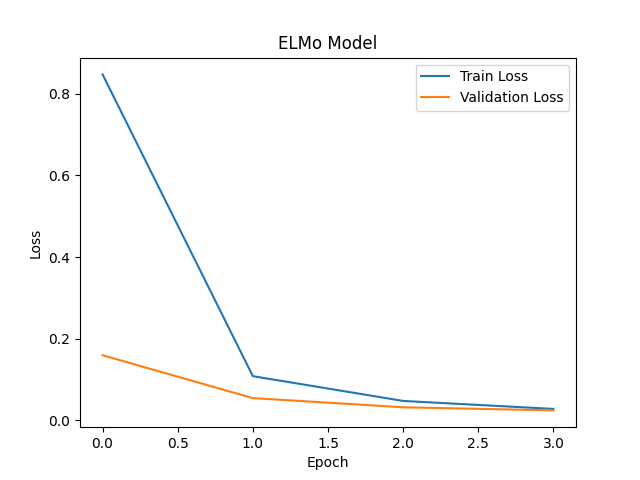

In [24]:
plt.plot(elmo_losses['epoch'], elmo_losses['train'], label='Train Loss')
plt.plot(elmo_losses['epoch'], elmo_losses['val'], label='Validation Loss')
plt.title('ELMo Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('ELMo.png')

In [25]:
for name, param in elmo.named_parameters():
    if param.requires_grad:
        print(name, param.data, param.shape)

embedding.weight tensor([[-0.0084, -0.1941,  0.0548,  ..., -0.1011, -0.1218,  0.2487],
        [-0.5200,  0.0844, -0.1673,  ..., -0.4624,  0.4968,  0.1783],
        [-0.1567,  0.3276,  0.9230,  ..., -0.2410, -0.2888,  0.5874],
        ...,
        [ 0.0756,  0.1120, -0.0674,  ...,  0.0522, -0.1142, -0.0570],
        [-0.3151,  0.2759, -0.2262,  ...,  0.5393, -0.5357, -0.1391],
        [ 0.7591, -0.5977, -0.6339,  ...,  0.2224, -0.3291,  0.4810]],
       device='cuda:0') torch.Size([44816, 100])
lstm1.weight_ih_l0 tensor([[ 0.0636,  0.2278,  0.1833,  ..., -0.1604,  0.2565,  0.0832],
        [ 0.1592,  0.1380, -0.2932,  ..., -0.5211,  0.1032,  0.2694],
        [-0.0113,  0.0346, -0.2548,  ..., -0.1364, -0.0049, -0.1550],
        ...,
        [-0.3474,  0.3750,  0.1137,  ...,  0.0371,  0.0769,  0.0513],
        [-0.0149,  0.0114, -0.0184,  ..., -0.1259,  0.0323,  0.2320],
        [ 0.0276,  0.0409,  0.0372,  ...,  0.1315, -0.0865, -0.0280]],
       device='cuda:0') torch.Size([400, 100])


In [26]:
elmo_embeddings = list(elmo.parameters())[0].cpu().detach().numpy()

In [27]:
torch.save(elmo_embeddings, 'elmo_embeddings.pt')

In [28]:
word = '<UNK>'
word_index = vocab[word]
elmo_embeddings[word_index]

array([-0.52004284,  0.08444769, -0.16729583, -0.1959439 , -0.402931  ,
       -0.15465549,  0.33042365,  0.4786426 ,  0.09207828, -0.5049792 ,
        0.10356513, -0.37924537, -0.3171873 ,  0.42669842,  0.12215655,
       -0.08844043,  0.5037824 , -0.6182677 , -0.24542682,  0.26402652,
        0.74965614,  0.14708453,  0.2834922 , -0.1017006 ,  0.11656577,
        0.2316335 ,  0.302055  , -0.29521623,  0.6289165 , -0.40557   ,
       -0.07529239,  0.26559177, -0.19542964,  0.52481115, -0.1650183 ,
        0.21860616,  0.0799165 ,  0.5283357 ,  0.5140917 , -0.330697  ,
       -0.04569887, -0.8665277 ,  0.3781111 , -0.22064723,  0.48155576,
       -0.26323855, -0.15771264,  0.0023865 , -0.10197838, -0.15878859,
        0.12744135,  0.5543115 ,  0.05984052,  0.3034634 , -0.67611307,
       -0.36209196, -0.08438193, -0.3115736 ,  0.2509349 ,  0.24638437,
       -0.23294638,  0.26103622, -0.5261799 ,  0.54576725,  0.3202514 ,
        0.3452566 ,  0.37269288,  0.10521681,  0.26412067, -0.32

In [29]:
elmo_lstm1 = elmo.lstm1
print(elmo_lstm1.parameters())
elmo_lstm2 = elmo.lstm2
print(elmo_lstm2.parameters())

<generator object Module.parameters at 0x7f58b1429fc0>
<generator object Module.parameters at 0x7f58b1429fc0>


In [30]:
elmo_embeddings = list(elmo.parameters())[0].to(device)

In [31]:
class SenClass(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size, max_len, embedding_matrix, elmo_embeddings, elmo_lstm1, elmo_lstm2, num_classes):
        super(SenClass, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.max_len = max_len
        self.embeddings = nn.Embedding.from_pretrained(elmo_embeddings)
        self.embeddings.weight = nn.Parameter(self.embeddings.weight, requires_grad=True)
        self.weights = nn.Parameter(torch.tensor([0.33, 0.33, 0.33]), requires_grad=True)
#         self.weights = nn.Parameter(torch.tensor([0.2, 0.2, 0.2]))
        self.lstm1_ft = elmo_lstm1
        self.lstm2_ft = elmo_lstm2
        self.linear1 = nn.Linear(embedding_dim, hidden_dim*2)
        self.linear2 = nn.Linear(hidden_dim*2, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_data):
        embeds = self.embeddings(input_data)
        embeds_change = self.linear1(embeds)
        hidden1, _ = self.lstm1_ft(embeds)
        hidden2, _ = self.lstm2_ft(hidden1)
        elmo_embed = (self.weights[0]*hidden1 + self.weights[1]*hidden2 + self.weights[2]*embeds_change)/(self.weights[0]+self.weights[1]+self.weights[2])
#         elmo_embed = (0.33*hidden1 + 0.33*hidden2 + 0.33*embeds_change)/(1)
        elmo_embed_max = torch.max(elmo_embed, dim=1)[0]
        elmo_embed_max_drop = self.dropout(elmo_embed_max)
        linear_out = self.linear2(elmo_embed_max_drop)
        return linear_out

sen_class = SenClass(len(vocab), 100, 100, batch_size, max_len, embedding_matrix, elmo_embeddings, elmo_lstm1, elmo_lstm2, 5)
print(sen_class)

SenClass(
  (embeddings): Embedding(44816, 100)
  (lstm1_ft): LSTM(100, 100, batch_first=True, bidirectional=True)
  (lstm2_ft): LSTM(200, 100, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=100, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [32]:
# elmo = elmo.to(device)
sen_class.to(device)
#Initializing optimizer
optimizer = optim.Adam(sen_class.parameters(), lr=0.001)
#Initializing loss function
criterion = nn.CrossEntropyLoss()

In [33]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

In [34]:
sen_class_losses = {'train': [], 'val': [], 'epoch': []}
sen_class_acc = {'train': [], 'val': [], 'epoch': []}
sen_class_f1 = {'train': [], 'val': [], 'epoch': []}
sc_lowest_val_loss = 1000
epochs = 5
for epoch in range(epochs):
    train_loss = 0
    train_acc = 0
    train_f1 = 0
    sen_class.train()
    for i, (forward_data, back_data, input_data, labels) in enumerate(train_loader):
        input_data = input_data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = sen_class(input_data)
        loss = criterion(output, labels)
        loss.backward()
        #update weights
        optimizer.step()
        #add loss to train_los
        train_loss += loss.item()
        _, preds = torch.max(output, 1)
        #get accuracy
        train_acc += accuracy_score(labels.cpu(), preds.cpu())
        #get micro f1 score
        train_f1 += f1_score(labels.data.cpu().numpy(), preds.cpu().numpy(), average='micro')
        #get confusion matrix
        if i%500 == 0:
            print('Epoch: {}/{}'.format(epoch+1, epochs), 'Step: {}'.format(i), 'Loss: {}'.format(loss.item()), 'Train Loss: {}'.format(train_loss/(i+1)))
    valid_loss = 0
    valid_acc = 0
    valid_f1 = 0
    sen_class.eval()
    for i, (forward_val, back_val, input_val, labels_val) in enumerate(valid_loader):
        input_val = input_val.to(device)
        labels_val = labels_val.to(device)
        outputs_val = sen_class(input_val)
        loss_val = criterion(outputs_val, labels_val)
        valid_loss += loss_val.item()
        #get predictions
        _, preds = torch.max(outputs_val, 1)
        #get accuracy
        valid_acc += accuracy_score(labels_val.cpu(), preds.cpu())
        #get micro f1 score
        valid_f1 += f1_score(labels_val.data.cpu().numpy(), preds.cpu().numpy(), average='micro')
        if 1%500 == 0:
            print('Epoch: {}/{}'.format(epoch+1, epochs), 'Step: {}'.format(i+1), 'Loss: {}'.format(loss.item()), 'Valid Loss: {}'.format(valid_loss/(i+1)))
    print('Epoch: {}/{}'.format(epoch+1, epochs), 'Train Loss: {}'.format(train_loss/(i+1)), 'Valid Loss: {}'.format(valid_loss/(i+1)))
    if valid_loss < sc_lowest_val_loss:
        sc_lowest_val_loss = valid_loss
        torch.save(sen_class.state_dict(), 'sen_class.pt')
        print('Clasification Model updated and saved')
    sen_class_losses['train'].append(train_loss/len(train_loader))
    sen_class_acc['train'].append(train_acc/len(train_loader))
    sen_class_f1['train'].append(train_f1/len(train_loader))
    sen_class_losses['epoch'].append(epoch+1)
    sen_class_acc['epoch'].append(epoch+1)
    sen_class_f1['epoch'].append(epoch+1)
    sen_class_losses['val'].append(valid_loss/len(valid_loader))
    sen_class_acc['val'].append(valid_acc/len(valid_loader))
    sen_class_f1['val'].append(valid_f1/len(valid_loader))

Epoch: 1/5 Step: 0 Loss: 1.734321117401123 Train Loss: 1.734321117401123
Epoch: 1/5 Step: 500 Loss: 1.165162444114685 Train Loss: 1.5863981758525034
Epoch: 1/5 Step: 1000 Loss: 1.2347352504730225 Train Loss: 1.4851834255379517
Epoch: 1/5 Step: 1500 Loss: 1.1876518726348877 Train Loss: 1.4099893308654774
Epoch: 1/5 Step: 2000 Loss: 1.3779504299163818 Train Loss: 1.3575931185189036
Epoch: 1/5 Step: 2500 Loss: 1.4041695594787598 Train Loss: 1.3228628778400444
Epoch: 1/5 Step: 3000 Loss: 1.3276615142822266 Train Loss: 1.2926645577053195
Epoch: 1/5 Step: 3500 Loss: 1.2458258867263794 Train Loss: 1.272182738617535
Epoch: 1/5 Step: 4000 Loss: 1.1553034782409668 Train Loss: 1.2553105555871402
Epoch: 1/5 Step: 4500 Loss: 0.8780314922332764 Train Loss: 1.2384694526789322
Epoch: 1/5 Step: 5000 Loss: 0.8562161326408386 Train Loss: 1.2273922061662725
Epoch: 1/5 Step: 5500 Loss: 1.4339237213134766 Train Loss: 1.2147015482593593
Epoch: 1/5 Step: 6000 Loss: 0.9173543453216553 Train Loss: 1.20680496275

In [35]:
#Printing the dictionary of accuracies
print('Losses:')
print(sen_class_losses)
#printing the dictionary of accuracies
print('Accuracy:')
print(sen_class_acc)
#printign the dictionary of f1 scores
print('Micro F1:')
print(sen_class_f1)

Losses:
{'train': [1.2021584028816223, 1.0100640522670745, 0.8932124496269226, 0.7734998568737507, 0.6608457766985893], 'val': [1.006259030617845, 0.9848960854184513, 1.0101550960312256, 1.1089053031164235, 1.2163685251729557], 'epoch': [1, 2, 3, 4, 5]}
Accuracy:
{'train': [0.46604, 0.56156, 0.61838, 0.6822, 0.73652], 'val': [0.5595047923322684, 0.5706869009584664, 0.5507188498402555, 0.5363418530351438, 0.5235623003194888], 'epoch': [1, 2, 3, 4, 5]}
Micro F1:
{'train': [0.46604, 0.56156, 0.61838, 0.6822, 0.73652], 'val': [0.5595047923322684, 0.5706869009584664, 0.5507188498402555, 0.5363418530351438, 0.5235623003194888], 'epoch': [1, 2, 3, 4, 5]}


<IPython.core.display.Javascript object>


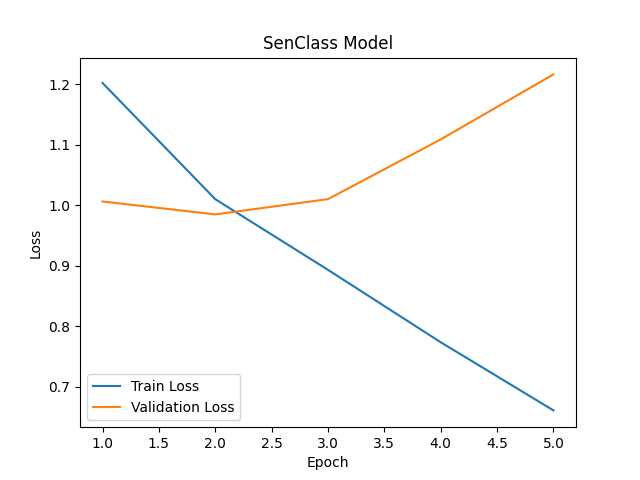

In [36]:
plt.plot(sen_class_losses['epoch'], sen_class_losses['train'], label='Train Loss')
plt.plot(sen_class_losses['epoch'], sen_class_losses['val'], label='Validation Loss')
plt.title('SenClass Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('SenClass.png')

<IPython.core.display.Javascript object>


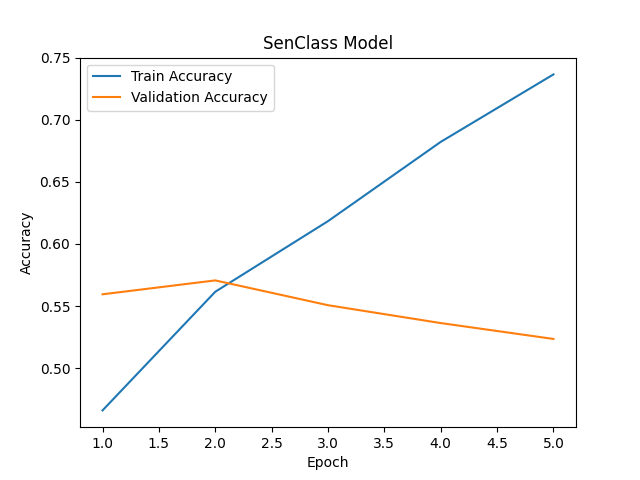

In [37]:
plt.plot(sen_class_acc['epoch'], sen_class_acc['train'], label='Train Accuracy')
plt.plot(sen_class_acc['epoch'], sen_class_acc['val'], label='Validation Accuracy')
plt.title('SenClass Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('SenClassAccuracy.png')

In [38]:
sen_class.load_state_dict(torch.load('sen_class.pt'))

<All keys matched successfully>

In [39]:
for name, param in sen_class.named_parameters():
    if param.requires_grad:
        print(name, param.data, param.shape)

weights tensor([0.2000, 0.2000, 0.2000], device='cuda:0') torch.Size([3])
embeddings.weight tensor([[-0.3211,  0.1231,  0.0491,  ..., -0.2576,  0.3599,  0.3295],
        [-0.4771,  0.0794, -0.0101,  ..., -0.5089,  0.6732,  0.1996],
        [-0.4559,  0.4080,  1.1131,  ..., -0.2006, -0.3810,  0.4413],
        ...,
        [ 0.0757,  0.1127, -0.1300,  ..., -0.0106, -0.1158, -0.1147],
        [-0.2892,  0.2765, -0.2257,  ...,  0.4765, -0.4741, -0.1398],
        [ 0.6968, -0.6607, -0.6968,  ...,  0.1601, -0.3293,  0.4815]],
       device='cuda:0') torch.Size([44816, 100])
lstm1_ft.weight_ih_l0 tensor([[ 0.2931,  0.0273, -0.2706,  ...,  0.0967,  0.1149, -0.1290],
        [ 0.1489,  0.2238, -0.3974,  ..., -0.4722,  0.1462,  0.3226],
        [-0.2598,  0.2084, -0.2029,  ..., -0.4032,  0.1898, -0.0751],
        ...,
        [-0.1365,  0.5516,  0.2886,  ...,  0.2845,  0.1222,  0.0222],
        [-0.0193,  0.0148,  0.1013,  ..., -0.1030,  0.2870,  0.2979],
        [ 0.2534, -0.0587, -0.0153,  ...

In [40]:
#Predictions on the Test Data
sen_class.load_state_dict(torch.load('sen_class.pt'))
sen_class.eval()
test_preds = []
for i, (forward_data, back_data, input_data, labels) in enumerate(test_loader):
    input_data = input_data.to(device)
    labels = labels.to(device)
    outputs = sen_class(input_data)
    #get predictions
    _, preds = torch.max(outputs, 1)
    test_preds.extend(preds.cpu().numpy())
#calculate micro f1 score
test_f1 = f1_score(test_labels, test_preds, average='micro')
print("F1 Micro:")
print(test_f1)
#calculate test accuracy
print("Accuracy:")
test_acc = accuracy_score(test_labels, test_preds)
print(test_acc)
#calculate confusion matrix
print("Confusion Matrix:")
test_confusion = confusion_matrix(test_labels, test_preds)
print(test_confusion)

F1 Micro:
0.4112
Accuracy:
0.4112
Confusion Matrix:
[[172 236 197 189 206]
 [175 221 223 169 212]
 [183 224 220 173 200]
 [178 226 196 190 210]
 [153 246 205 171 225]]
